# Name: Mohamed Mahmoud Rezk
# ID: 2002114

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

## metrics imports
import sklearn.metrics as metrics 

%matplotlib inline

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
data.columns

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')

In [4]:
data.shape

(863, 15)

### Dropping the `Unnamed: 0` column 

In [5]:
data.drop(columns=["Unnamed: 0"], inplace=True)

### Looking at the description of the data

In [6]:
data.describe()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


In [7]:
print("Unique Values for each column")
for col in data.columns:
    print(col, data[col].nunique())

Unique Values for each column
location 139
country 34
gender 3
age 81
vis_wuhan 2
from_wuhan 2
symptom1 25
symptom2 32
symptom3 20
symptom4 13
symptom5 4
symptom6 2
diff_sym_hos 18
result 2


## Observations

make a heatmap to the correlation between columns

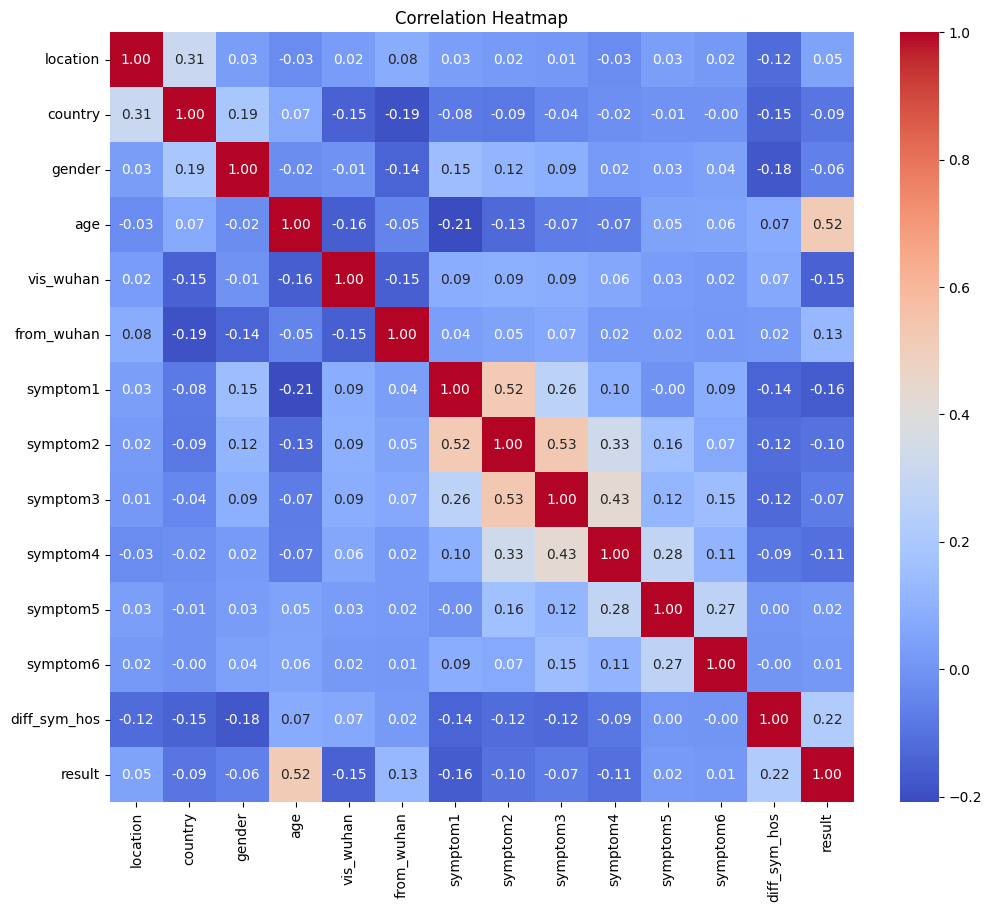

In [8]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### PROBLEM 1: There is a third gender (value of `2`)  

In [9]:
data["result"].value_counts()

result
0    755
1    108
Name: count, dtype: int64

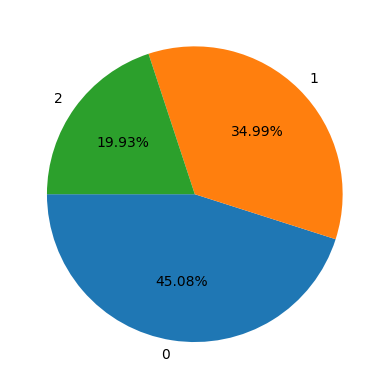

In [10]:
plt.pie(data["gender"].value_counts(), labels=[0,1,2], startangle=180, autopct="%2.2f%%")
plt.show()

#### FIX: Since the "third/undefined" gender takes around 20% of the data, the `gender` column can be omitted

In [11]:
data.drop(columns=["gender"], inplace=True)

### PROBLEM 2: the min value of `diff_sym_hos` column is negative

In [12]:
data[data["diff_sym_hos"] < 0]

,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
223,56,18,35.0,0,0,6,31,19,12,3,1,-1,0
240,128,18,65.0,0,0,6,31,19,12,3,1,-5,0


#### FIX: Dropping rows that have negative values in `diff_sym_hos` column

In [13]:
negative_diff_idxs = data[data["diff_sym_hos"] < 0].index.values.tolist()
data.drop(index=negative_diff_idxs, inplace=True)
data.shape

(861, 13)

### PROBLEM 3: `symptom6` column experiences no variation 

In [14]:
data["symptom6"].value_counts()

symptom6
1    860
0      1
Name: count, dtype: int64

#### FIX: dropping the `symptom6` column

In [15]:
data.drop(columns=["symptom6"], inplace=True)
data.shape

(861, 12)

## Preparing features for training

In [16]:
X = data.loc[:, data.columns != "result"]
y = data["result"]
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Normalizing training data

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Preparing mertics functions

In [18]:
CLASSIFIERS_SCORES = {}
metrics_funcs = {
    "Accuracy": metrics.accuracy_score,
    "Precision": metrics.precision_score,
    "Recall": metrics.recall_score,
    "F1-score": metrics.f1_score,
    "ROC/AUC": metrics.roc_auc_score,
}

def compute_model_metrics(y_true, y_pred):
    res = dict()
    for metric in metrics_funcs:
        res[metric] = metrics_funcs[metric](y_true, y_pred)
    return pd.DataFrame(res.items())

def display_confusion_matrix(y_true, y_pred):
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=[0,1])
    plt.show()

def display_roc_graph(y_true, y_pred, name=None):
    metrics.RocCurveDisplay.from_predictions(y_true, y_pred, name=name+" Classifier")
    plt.show()


# K-Nearest Neighbours Classifier

### Finding the best K with cross validation

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
cv_scores = []
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10, scoring="accuracy").mean()
    cv_scores.append(score)
best_k = np.argmax(cv_scores) + 1
best_k

np.int64(1)

### Compute knn model metrics using the `best_k`

In [20]:
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm="brute")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_metrics = compute_model_metrics(y_test, y_pred_knn)
CLASSIFIERS_SCORES["KNN"] = knn_metrics
print("KNN Metrics")
print(knn_metrics)

KNN Metrics
           0         1
0   Accuracy  0.936416
1  Precision  0.789474
2     Recall  0.681818
3   F1-score  0.731707
4    ROC/AUC  0.827664


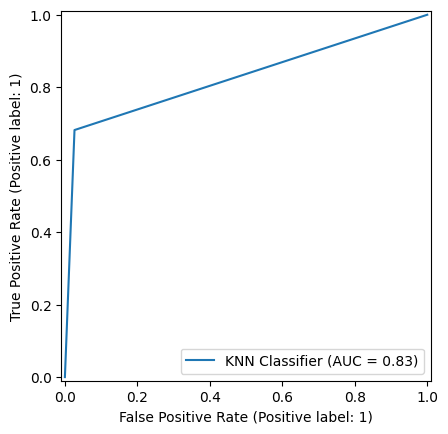

In [21]:
display_roc_graph(y_test, y_pred_knn, name="KNN")

In [22]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       151
           1       0.79      0.68      0.73        22

    accuracy                           0.94       173
   macro avg       0.87      0.83      0.85       173
weighted avg       0.93      0.94      0.93       173



# Logistic Regression Classifier

In [23]:
from sklearn.linear_model import LogisticRegression

logestic_model = LogisticRegression()


In [24]:
logestic_model.fit(X_train, y_train)

LogisticRegression()

In [25]:
y_pred_logistic = logestic_model.predict(X_test)

In [26]:
logestic_model_best = LogisticRegression()

In [27]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'multi_class': ['auto', 'ovr', 'multinomial']
}
grid_search = GridSearchCV(estimator=logestic_model_best, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_



c:\Users\Marten\Desktop\myself\ML pro\env_for_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Marten\Desktop\myself\ML pro\env_for_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Marten\Desktop\myself\ML pro\env_for_ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Marten\Desktop\myself\ML pro\env_for_ML\Lib\site-packag

In [28]:
print('best_params:', best_params)

best_params: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'tol': 0.0001}


In [29]:
y_pred_logistic_best = grid_search.predict(X_test)
print(metrics.classification_report(y_test,y_pred_logistic_best))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       151
           1       0.85      0.50      0.63        22

    accuracy                           0.92       173
   macro avg       0.89      0.74      0.79       173
weighted avg       0.92      0.92      0.92       173



In [30]:
print(metrics.classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       151
           1       0.85      0.50      0.63        22

    accuracy                           0.92       173
   macro avg       0.89      0.74      0.79       173
weighted avg       0.92      0.92      0.92       173



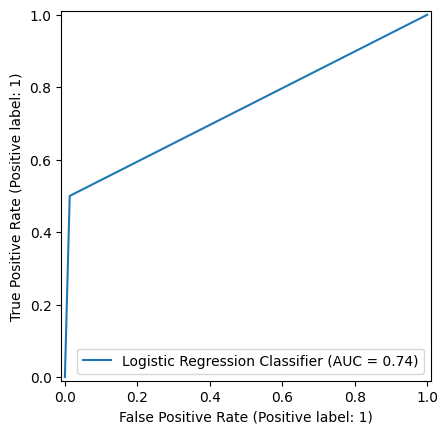

In [31]:
display_roc_graph(y_test, y_pred_logistic, name="Logistic Regression")


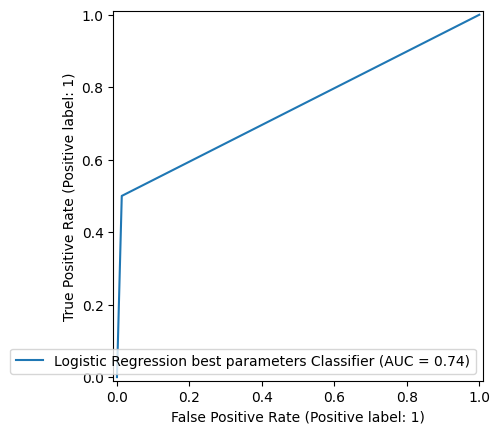

In [33]:
display_roc_graph(y_test, y_pred_logistic_best, name="Logistic Regression best parameters")


Niyve bas

In [ ]:
data2=data.drop(columns=["symptom5"], inplace=True)



In [44]:
data2=data

In [ ]:
data2.drop(columns=["symptom5"], inplace=True)

In [45]:
X = data2.loc[:, data2.columns != "result"]
y = data2["result"]
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [46]:
gnb = GaussianNB()

In [47]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [48]:
naive_bayes_metrics = compute_model_metrics(y_test, y_pred_gnb)
CLASSIFIERS_SCORES["Naive Bayes"] = naive_bayes_metrics
print("Naive Bayes Metrics:")
print(naive_bayes_metrics)


Naive Bayes Metrics:
           0         1
0   Accuracy  0.861272
1  Precision  0.464286
2     Recall  0.590909
3   F1-score  0.520000
4    ROC/AUC  0.745786


In [52]:
naive_bayes_metrics = compute_model_metrics(y_test, y_pred_gnb)
CLASSIFIERS_SCORES["Naive Bayes"] = naive_bayes_metrics
print("Naive Bayes Metrics:")
print(naive_bayes_metrics)


Naive Bayes Metrics:
           0         1
0   Accuracy  0.861272
1  Precision  0.464286
2     Recall  0.590909
3   F1-score  0.520000
4    ROC/AUC  0.745786


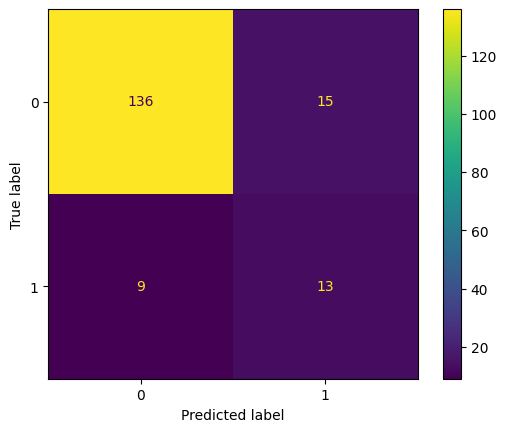

In [50]:
display_confusion_matrix(y_test, y_pred_gnb)


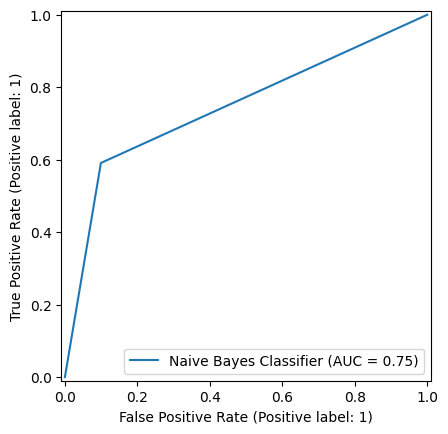

In [51]:
display_roc_graph(y_test, y_pred_gnb, name="Naive Bayes")
